In [38]:
import numpy as np
import pennylane as qml
from pennylane import qchem
import matplotlib.pyplot as plt

We now need to get the molecular hamiltonian of $LiH$ through qchem's library molecular_hamiltonian function, which gives us the hamiltonian in the form a Pauli String (a linear combination of Pauli matrices and the identity matrix):

In [92]:
symbols = ["Li", "H"]
coordinates = np.array([[0, 0,  0], [0, 1.596, 0]])
hamiltonian, num_qubits = qchem.molecular_hamiltonian(symbols, coordinates)
print(num_qubits)

12


In [93]:
numQubits = int(input("number of qubits :"))
numElec = int(input("number of electrons :"))

We prepare our qubits initially in a Hartree-Fock state, which is obtained by minimizing the interaction energy of each electron with the average field produced by the other electrons, leaving out electron-electron correlations. This justifies the need to further refine this approach by resorting to the VQE algorithm to effectively find the ground state of the system.
Since qubits, in quantum chemistry, are encoding spin orbitals, the Fock-Hartree state, in which the electrons will first try to occupy the lowest energy orbitals, is always represented with the qubit $\ket{1...1 0...0}$ with as much ones as there are electrons.
will use 20 qubits since $N_{2}$ has 10 molecular orbitals, multiplied by two to account for the spin-up and spin-down spin orbitals :

In [94]:
HFstate = [1 for i in range(numElec)] + [0 for i in range(numQubits - numElec)]

print(HFstate)

[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]


We want to build our "Operator Pool"; which is all the list of all operators that we will need to build our ansatz, which will be a superposition of the Hartree-Fock state $\ket{1...10...0}$ and the states obtained through either a single-excitation or a double-excitation of the Hartree-Fock state. Thus we will resort to single and double-excitation gates $G(\theta)$ and $G^{(2)}(\theta)$, which respectively introduce a coupling between $\ket{01}$ and $\ket{10}$, and between $\ket{0011}$ and $\ket{1100}$ : $$G^{(2)}(\theta)\ket{0011} = \cos(\frac{\theta}{2})\ket{0011} + \sin(\frac{\theta}{2})\ket{1100}$$
$$G^{(2)}(\theta)\ket{1100} = \cos(\frac{\theta}{2})\ket{1100} - \sin(\frac{\theta}{2})\ket{0011}$$
So we code a function that gives us the list of all single and double-excitation, these have to verify the spin selection rule $\Delta S = 0$ rule, stating that a given excitation, the variation in spin of the molecule must be zero :





In [95]:
def singleExcitations(numberOfElectrons, numberOfQubits) :
    single = []
    for i in range(numberOfElectrons) :
        j = numberOfElectrons
        if (j % 2 != i % 2) : #verify if j and i correspond to different spin
            j += 1 #we add 1 so that j and i have same spin hence verifying the spin selection rule
        while (j < numberOfQubits) :
            single.append([i, j])
            j+=2
    return single


def doubleExcitations(numberOfElectrons, numberOfQubits) :
    double = []
    for electron1 in range(14) :
        for electron2 in range(electron1 + 1, numberOfElectrons) :
            if (electron1 % 2 == 0 and electron2 % 2 == 0 ) : #both spins are positive
                newOrbital1 = numberOfElectrons + (numberOfElectrons % 2) #it must be an orbital with +1/2spin
                toAdd = 2
            elif (electron1 % 2 == 1 and electron2 % 2 == 1 ) : # both spins are negative
                newOrbital1 = numberOfElectrons + (1 - numberOfElectrons % 2) #it must be an orbital with -1/2spin
                toAdd = 2
            else :  #the spins of the transitionning electrons are opposite
                newOrbital1 = numberOfElectrons
                toAdd = 1 #the spin orbitals must have opposite spin
            while (newOrbital1 < numberOfQubits) :
                newOrbital2 = newOrbital1 + toAdd
                while (newOrbital2 < numberOfQubits ) :
                    double.append([electron1, electron2, newOrbital1, newOrbital2])
                    newOrbital2 += 2
                newOrbital1 += toAdd
    return double
                    

def excitations(numberOfElectrons, numberOfQubits) :
    return singleExcitations(numberOfElectrons, numberOfQubits), doubleExcitations(numberOfElectrons, numberOfQubits)

print(excitations(numElec, numQubits))

single, double = excitations(numElec, numQubits)

([[0, 4], [0, 6], [0, 8], [0, 10], [1, 5], [1, 7], [1, 9], [1, 11], [2, 4], [2, 6], [2, 8], [2, 10], [3, 5], [3, 7], [3, 9], [3, 11]], [[0, 1, 4, 5], [0, 1, 4, 7], [0, 1, 4, 9], [0, 1, 4, 11], [0, 1, 5, 6], [0, 1, 5, 8], [0, 1, 5, 10], [0, 1, 6, 7], [0, 1, 6, 9], [0, 1, 6, 11], [0, 1, 7, 8], [0, 1, 7, 10], [0, 1, 8, 9], [0, 1, 8, 11], [0, 1, 9, 10], [0, 1, 10, 11], [0, 2, 4, 6], [0, 2, 4, 8], [0, 2, 4, 10], [0, 2, 6, 8], [0, 2, 6, 10], [0, 2, 8, 10], [0, 3, 4, 5], [0, 3, 4, 7], [0, 3, 4, 9], [0, 3, 4, 11], [0, 3, 5, 6], [0, 3, 5, 8], [0, 3, 5, 10], [0, 3, 6, 7], [0, 3, 6, 9], [0, 3, 6, 11], [0, 3, 7, 8], [0, 3, 7, 10], [0, 3, 8, 9], [0, 3, 8, 11], [0, 3, 9, 10], [0, 3, 10, 11], [1, 2, 4, 5], [1, 2, 4, 7], [1, 2, 4, 9], [1, 2, 4, 11], [1, 2, 5, 6], [1, 2, 5, 8], [1, 2, 5, 10], [1, 2, 6, 7], [1, 2, 6, 9], [1, 2, 6, 11], [1, 2, 7, 8], [1, 2, 7, 10], [1, 2, 8, 9], [1, 2, 8, 11], [1, 2, 9, 10], [1, 2, 10, 11], [1, 3, 5, 7], [1, 3, 5, 9], [1, 3, 5, 11], [1, 3, 7, 9], [1, 3, 7, 11], [1, 3, 9,

However taking into account all these excitations is computationally expensive for larger molecule and makes the algorithm more prone to errors, especially since we interate until we reach convergence, hence we should select the most significant excitations : to do that, we calculate the gradient of all these excitations, only keeping excitations for which the absolute value of the derivative of the expectation value of the hamiltonian with respect to the parameter associated to the excitation is past a certain threshhold (this is the basis of adaptive VQE), so we code a function to calculate the gradient of all excitations. We use the parameter-shift rule, which allows us to calculate the gradient at the same time of calculating the output of the quantum circuit. It states that for a parameter $\theta_i$, we have for an observable H :
$$\frac{\partial \langle H \rangle}{\partial \theta} = \frac{1}{2} \left( \langle \psi(\theta + \frac{\pi}{2}) | H | \psi(\theta + \frac{\pi}{2}) \rangle - \langle \psi(\theta - \frac{\pi}{2}) | H | \psi(\theta - \frac{\pi}{2}) \rangle \right)$$
We start by designing the circuit, then we will apply the parameter-shift rule :

In [98]:


single, double = excitations(numElec, numQubits)

dev = qml.device("default.qubit", wires = numQubits) #we define the parameters of our circuits

def circuit(parameters) :
    i = 0 #index of the parameter
    qml.BasisState(HFstate, wires = range(numQubits))
    single, double = excitations(numElec, numQubits)

    for s in single :
        qml.SingleExcitation(parameters[i], wires = s)
        i+= 1

    for d in double :
        qml.DoubleExcitation(parameters[i], wires = d)
        i+= 1
@qml.qnode(dev)

def costFunction(parameters) :
    circuit(parameters)
    return qml.expval(hamiltonian)


In [99]:
def gradient(cost_fn, params):
    grad = np.zeros(len(params))
    for j in range(len(params)) :
        storedValue = params[j]
        params[j] += np.pi/2
        forwardShift = params.copy()
        params[j] -= np.pi
        backwardShift = params.copy()
        grad[j] = 1/2 * (cost_fn(forwardShift) - cost_fn(backwardShift))
        params[j] = storedValue #reset the parameter value to its previous value for the next derivative computation
    return grad

In [100]:
selectedSingle = []
selectedDouble = []  

lengthSingle = len(single)
lengthDouble = len(double)
param1 = [0]*(lengthSingle + lengthDouble)

grad = gradient(costFunction, param1)
for j in range(lengthSingle) :
    if (abs(grad[j]) > 10E-8) :
        selectedSingle.append(single[j])
for j in range(lengthSingle, lengthSingle + lengthDouble) :
    if (abs(grad[j]) > 10E-8) :
        selectedDouble.append(double[j - lengthSingle])

    

It is worth noting that due to the great number of gates used, the calculation of the gradient is very costly (for big molecules) since it implies the execution of the unoptimized circuit twice for each excitation gate, which means that, in order to gain an advantage from this approach, one has to build and keep, through this method, a database of all relevant excitations for future computations.


We now define the optimized circuit, which now only uses relevant gates, and the associated cost function :

In [101]:

def optimizedCircuit(parameters) :
    i = 0 #index of the parameter
    qml.BasisState(HFstate, wires = range(numQubits))
    for s in selectedSingle :
        qml.SingleExcitation(parameters[i], wires = s)
        i+= 1
    for d in selectedDouble :
        qml.DoubleExcitation(parameters[i], wires = d)
        i+= 1

@qml.qnode(dev)
def optiCostFunction(parameters) :
    optimizedCircuit(parameters)
    return qml.expval(hamiltonian)

param2 = [0]*(len(selectedSingle) + len(selectedDouble))

We can now code our classical optimization routine, which will be through gradient descent, in order to compute the ground state energy :

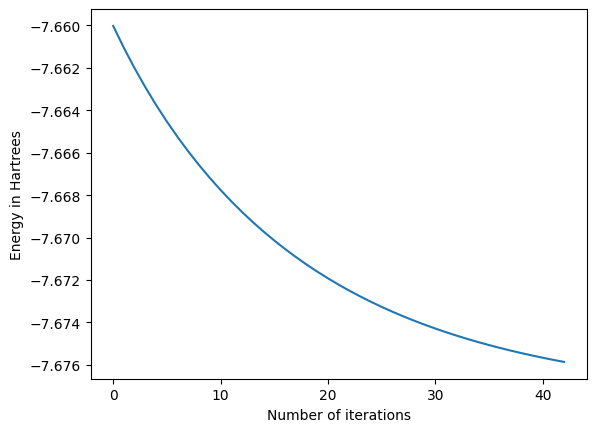

the ground state energy is : -7.675860946076592 Ha


In [109]:
def gradDescent2(cost_fn, params, stepsize, maxiter, epsilon) : #param are the initial parameters
    a = np.array([params, params - gradient(cost_fn, params) * stepsize])
    n = 0
    while (n < maxiter) :
        if abs(cost_fn(a[n]) - cost_fn(a[n+1])) < epsilon :
            break
        n += 1
        a = np.vstack([a, a[n] - stepsize * gradient(cost_fn, a[n])])

    e0 = [cost_fn(a[k]) for k in range(n+2)]
    plt.plot(range(len(a)), e0)
    plt.xlabel('Number of iterations')
    plt.ylabel('Energy in Hartrees')
    plt.show()
    
    return cost_fn(a[n+1]) , a[n+1]   


energy, final_param = gradDescent2(optiCostFunction, param2, 0.05, 60, 1e-4)
print("the ground state energy is :", energy, 'Ha')

We find a ground state energy of -7.66 Hartrees, while it is actually closer to -7,8 Hartrees. This shows that the energy landscape of the $LiH$ molecule is quite complex and highlights that ground state calculation is challenging computation for VQEs that is based on gradient-descent, which it our case might have converged to a local minima.

References :

[1] Pennylane documentation, Variational Quantum Eigensolver :

https://docs.pennylane.ai/projects/catalyst/en/latest/demos/adaptive_circuits_demo.html

[2] Pennylane, Givens rotations for quantum chemistry :

https://pennylane.ai/qml/demos/tutorial_givens_rotations/ 

[3] Pennylane,  Variational Quantum Eigensolver (VQE) | PennyLane Tutorial :

https://www.youtube.com/watch?v=qiRtUUZ5s9s&ab_channel=PennyLane 

[4] Practical QC for Scientists, Parameter-shift rules :

https://obm.physics.metu.edu.tr/intro-QC/courses/PHYS710/hands-on/hands-on-6/hands-on-6-book.html
